In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv("../data/customer_booking.csv", encoding='ISO-8859-1')

In [4]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

In [6]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [7]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [8]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [9]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [10]:
df["trip_type"].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [11]:
df["sales_channel"].unique()

array(['Internet', 'Mobile'], dtype=object)

In [12]:
df['route'].nunique()

799

In [13]:
df['booking_origin'].nunique()

104

In [14]:
df = pd.get_dummies(df, columns=['sales_channel', 'trip_type', 'route', 'booking_origin'], drop_first=True)

### Feature Engineering

Analyze length_of_stay to create "short stay", "medium stay", "long stay".

In [15]:
# Creating a feature that categorizes length_of_stay
df['stay_category'] = pd.cut(df['length_of_stay'], bins=[0, 3, 7, 14, 30], labels=['short', 'medium', 'long', 'very_long'])
df = pd.get_dummies(df, columns=['stay_category'], drop_first=True)

Normalization

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['purchase_lead', 'flight_duration', 'flight_hour']] = scaler.fit_transform(df[['purchase_lead', 'flight_duration', 'flight_hour']])

### Train ML Model

In [17]:
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

### Model Evaluation

In [20]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.848875 0.849625 0.848125 0.84675  0.85425 ]
Mean CV score: 0.8495250000000001


In [21]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      8520
           1       0.54      0.13      0.21      1480

    accuracy                           0.85     10000
   macro avg       0.70      0.55      0.56     10000
weighted avg       0.82      0.85      0.81     10000

ROC AUC Score: 0.5548439284354777


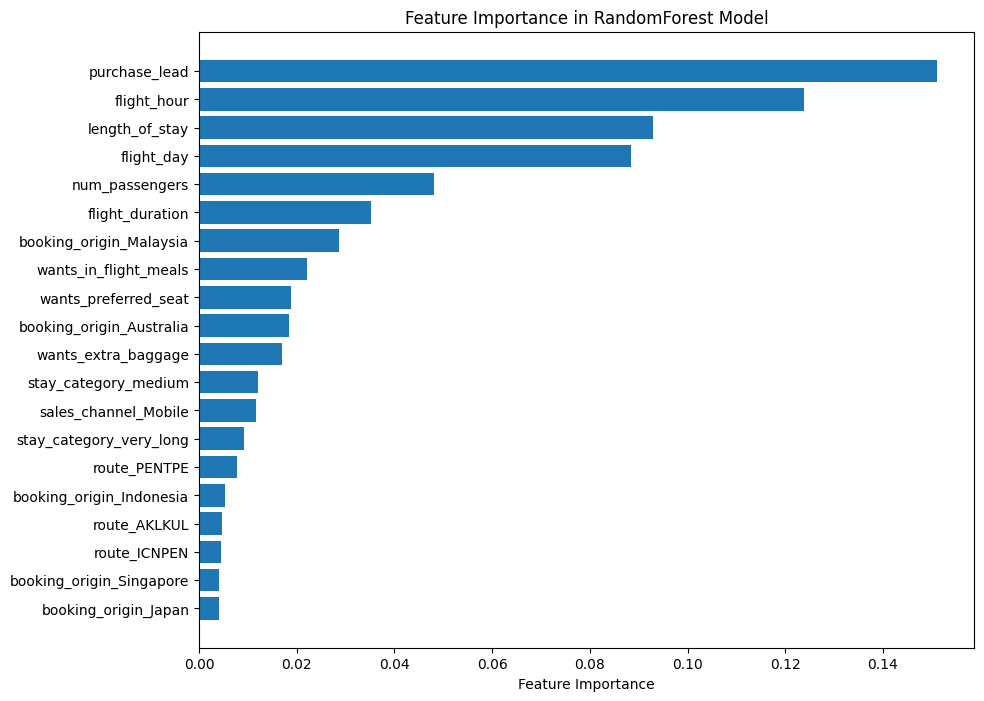

In [22]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[-20:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in RandomForest Model')
plt.show()

In [23]:
from sklearn.utils import resample

In [24]:
# Separate majority and minority classes
df_majority = df[df.booking_complete == 0]
df_minority = df[df.booking_complete == 1]

In [25]:
df_minority_oversampled = resample(df_minority, 
                                   replace=True,     # Sample with replacement
                                   n_samples=len(df_majority),    # Match number in majority class
                                   random_state=42)  # Reproducible results

In [26]:
df_oversampled = pd.concat([df_majority, df_minority_oversampled])

In [27]:
# Splitting the data into features and target
X_oversampled = df_oversampled.drop('booking_complete', axis=1)
y_oversampled = df_oversampled['booking_complete']

# Train-test split for oversampled data
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=42)

# Training the RandomForest model on oversampled data
model_over = RandomForestClassifier(n_estimators=100, random_state=42)
model_over.fit(X_train_over, y_train_over)


RandomForestClassifier(random_state=42)

In [28]:
# Evaluate the oversampled model
y_pred_over = model_over.predict(X_test_over)
print("Data Classification Report:")
print(classification_report(y_test_over, y_pred_over))
print("ROC AUC Score:", roc_auc_score(y_test_over, y_pred_over))

Data Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      8513
           1       0.92      0.99      0.96      8496

    accuracy                           0.95     17009
   macro avg       0.96      0.95      0.95     17009
weighted avg       0.96      0.95      0.95     17009

ROC AUC Score: 0.9534170059063317
